## Prerequisites
- Decision Tree

- Familiarity with Object-Oriented Programming in Python
- Comfortable with graph data structures

# Decision Tree Implementation from Scratch

In the previous notebook, we discussed decision tree algorithms and impurity metrics. Here, we’ll **implement a simplified version of decision tree from scratch using Python** and its libraries.

## Algorithm (Gini-Based, No Pruning)

1. For all instances in a dataset ($D$):  
   - **If** all instances belong to the same class $C$, or stopping criteria (e.g., max depth, pure node) are met:  
     → **Create a leaf node** and stop.

   - **Else**:  
   
     → Compute **Gini impurity** for all attributes.  
     → Select the attribute (say, $f$) with the **lowest Gini**.  
     → Split the data based on values of attribute $f$.

2. **Recursively apply** the algorithm to each resulting subset.

> __Notes:__
>
> - This algorithm **does not use pruning** (unlike CART or C4.5).
>
>   _**Pruning** is the process of removing unnecessary parts of a decision tree._
>
> - It’s **similar to ID3**, but instead of **entropy**, we use **Gini impurity**.
>
> - Another important difference is the way we handle numerical attributes. We will be using the approach discussed in the chapter **Impurity metrics**. The steps can be summarized as below:
>
>   1. Compute potential threshold values for each attribute.
>
>   2. Use each threshold value to compute the impurity metric(gini).
>   3. Repeat steps 1 and 2 for all attributes and threshold values.
>   4. Choose the threshold and attribute value corresponding to the lowest gini to create the split.

In [1]:
# Let's import the necessary libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn import datasets

### Loading and splitting the dataset

In this notebook, we will use the **iris** dataset from sklearn's [`datasets`](https://scikit-learn.org/stable/datasets/index.html) module. We will create a pandas dataframe using the loaded data so that it is easier to create our own `train_test_split` function.

In [2]:
iris = datasets.load_iris()

# Convert the data into dataframe
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [3]:
feature_names, class_names = iris.feature_names, iris.target_names
print("Feature Names:", feature_names)
print("Target Names:", class_names)

Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target Names: ['setosa' 'versicolor' 'virginica']


Now let us write a function to split the original dataset into train and test set.

In [4]:
def train_test_split(df, test_size):
    if isinstance(test_size, float):
        """
        If test_size is float multiply by the length of dataframe to
        compute the test size of the dataset.
        """
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df, test_df

Using the above function, let's divide the dataset into train and test set. We will keep $20$ instances in the test set. For reproducibility, we will also set the `random_seed` to $0$.

In [5]:
random.seed(0)
train_df, test_df = train_test_split(data, test_size=20)
train_df.shape, test_df.shape

((130, 5), (20, 5))

`train_df` and `test_df` hold the train and test data, respectively.

### Helper Functions


From the above algorithm for decision tree, it is clear that we will need to implement different functions. The list below represents functions we need to create:

* `compute_gini()` - Function to compute gini for the given data.
* `compute_weighted_gini()` - Function to compute weighted gini for given splits/nodes.
* `split_data()` - Function to split the input data into two halves around the given split value.
* `get_potential_splits()` - Function to generate/find the potential splits(threshold values).
* `determine_best_split()` - Function to find the best split from a list of potential splits.

The function below, `compute_gini()` uses the following formula to compute gini:  
  
$$\text{Gini} = 1 - \sum_{i=1}^{c}{P_i^2}$$  
Where,   
$c = $ Total number of labels/classes.   
$P_i = $ Probability of an item belonging to class $i$.

In [6]:
def compute_gini(data):
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    gini  = 1 - sum(probabilities ** 2)

    return gini

Let's take train set samples (without split) and see how the `compute_gini()` function calculates the Gini impurity on them.

In [7]:
print(compute_gini(train_df.to_numpy()))

0.6660355029585798


> **Gini impurity = 0.666** (or **~2/3**) means the data is **quite impure**, i.e., the class labels are mixed and evenly distributed among 3 classes.

The function below,`compute_weighted_gini()`, computes the weighted average of gini for the left and right child.

$$\text{Weighted gini} = \frac{n_L}{n}*\text{Gini}_\text{left} + \frac{n_R}{n}*\text{Gini}_\text{right}$$
Where,

- $n_L =$ Number of instances in the left child.   
- $n_R =$ Number of instances in the right child.   
- $n = $ Total number of instances $= n_L + n_R$.   
- $\text{Gini}_\text{left} = $ Gini impurity of the left child.   
- $\text{Gini}_\text{right} = $ Gini impurity of the right child.  

In [8]:
def compute_weighted_gini(left_child, right_child):
    n = len(left_child) + len(right_child)
    p_left_child = len(left_child) / n
    p_right_child = len(right_child) / n

    weighted_gini =  (p_left_child * compute_gini(left_child)
                        + p_right_child * compute_gini(right_child))

    return weighted_gini

In [9]:
def split_data(data, split_column, split_value):
    """ Function to split the data into two parts """
    split_column_values = data[:, split_column]

    left_child = data[split_column_values <= split_value]
    right_child = data[split_column_values > split_value]

    return left_child, right_child

Let's say we want to **split based on feature** - *petal length (cm)* at **threshold $2.5$**


In [10]:
data = train_df.to_numpy()
split_column = feature_names.index("petal length (cm)")
split_value = 2.5

left_child, right_child = split_data(data, split_column, split_value)
compute_weighted_gini(left_child, right_child)

np.float64(0.3230769230769231)


The Gini impurity value of **0.323** indicates a **moderate level of class purity**. This means that, after splitting the data at a petal length threshold of **2.5 cm**, one class tends to dominate in the resulting subset.

Let's create two functions — `get_potential_splits` and `determine_best_split` to systematically evaluate possible splits and select the best one based on minimizing the weighted Gini impurity. This will help us choose the most effective split for our decision tree.


#### `get_potential_splits` finds potential split values for all feature columns in the dataset

1. Loop through each feature column.

2. Find unique sorted values for that feature.
3. Calculate midpoints between every two consecutive unique values.
4. Store these midpoints as potential split points for the feature.

In [11]:
def get_potential_splits(data):
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):   # Excluding the last column which is the label
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)

        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]
                potential_split = (current_value + previous_value) / 2

                potential_splits[column_index].append(potential_split)

    return potential_splits

####`determine_best_split` gets the best split from an array of potential_splits. The best split is the one that yields the lowest/minimum gini.

1. Initialize a variable to hold the best (lowest) Gini impurity found so far.

2. For each feature column in potential splits:
3. For each candidate split value in that feature:
    - Split the dataset into two parts based on the split value.
    - Calculate the weighted Gini impurity of the split.
    - If this Gini is lower than the best found so far, update the best split info.
4. After checking all splits, return the feature and value that yielded the lowest Gini impurity.

In [12]:
def determine_best_split(data, potential_splits):
    overall_gini = 9999     # Since we need to find lowest gini, we initialize

    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_gini = compute_weighted_gini(data_below, data_above)

            if current_overall_gini <= overall_gini:
                overall_gini = current_overall_gini
                best_split_column = column_index
                best_split_value = value

    return best_split_column, best_split_value

To create and train our decision tree, we will create two classes:

* `Node`: This class represents each node in a decision tree. It also contains functions to check if a node is pure and function to assign a label to a node.

* `DecisionTree`: This class represents the entire decision tree. It contains functions to train the tree and make predictions using the tree. It uses the Node class to arrange nodes in a tree.

In [13]:
class Node:
    """Class to represent Node in a decision tree node"""

    def __init__(self, parent=None, left_child=None, right_child=None, data=None,
                gini=None, label=None, is_leaf=None, split_column=None,
                split_value=None, question=None, depth=None):
        self.parent = parent                # Parent of current node
        self.left_child = left_child        # Left child of current node
        self.right_child = right_child      # Right child of current node
        self.data = data                    # Data to be stored in the node
        self.label = label                  # Label associated with the node
        self.is_leaf = is_leaf              # Identifies if a node is a leaf or not
        self.split_column = split_column    # Feature to test for the node
        self.split_value = split_value      # Split value for the node
        self.question = question            # Question representing the test performed in the node
        self.depth = depth                  # Depth of the node

    def is_pure(self):
        """ Returns Boolean if the data in a node are pure (same label) or not"""
        target = self.data[:, -1]
        unique_classes = np.unique(target)
        if len(unique_classes) == 1:
            return True
        else:
            return False

    def set_label(self):
        """Assigns a label to a node."""
        target = self.data[:, -1]
        unique_classes, counts_unique_classes = np.unique(target, return_counts=True)

        index = counts_unique_classes.argmax()
        classification = unique_classes[index]
        self.label = classification

In [14]:
class DecisionTree:
    """Class to represent Decision tree"""
    def __init__(self,min_samples=2, max_depth=9999, root=None, features=None):
        self.root = root                # Root node of the decision tree
        self.root.depth = 0             # Depth of root, a constant value set to 0
        self.max_depth = max_depth      # Maximum allowed depth for the decision tree
        self.features = features        # Names of features of the data
        self.min_samples = min_samples  # Minimum samples allowed in a node

    def train_tree(self, node):
        """Recursively trains a decision tree"""
        if node.parent:
            node.depth = node.parent.depth + 1

        if node.is_pure() or len(node.data)<=self.min_samples or node.depth == self.max_depth:
            node.is_leaf = True
            node.set_label()

        else:
            potential_splits = get_potential_splits(node.data)
            split_column, split_value = determine_best_split(node.data,
                                                            potential_splits)

            node.split_column = split_column
            node.split_value = split_value

            data_below, data_above = split_data(node.data, split_column,
                                                split_value)

            node_left = Node(parent=node, data=data_below)
            node_right = Node(parent=node, data=data_above)

            node.left_child = node_left
            node.right_child = node_right
            node.question = "{} <= {}".format(self.features[split_column], split_value)

            self.train_tree(node_left)
            self.train_tree(node_right)

    def predict(self, X):
        """Predicts class label(s) for one or more instances"""
        if X.ndim == 1:
            return self._predict_instance(X)
        else:
            return np.array([self._predict_instance(instance) for instance in X])

    def _predict_instance(self, instance):
        node = self.root
        while not node.is_leaf:
            if instance[node.split_column] <= node.split_value:
                node = node.left_child
            else:
                node = node.right_child
        return node.label


    def get_root(self):
        """Returns the root node of the decision tree"""
        return self.root

After writing all the required methods and classes, let's initialize the `Node()` object. It will be used as a root node for the decision tree. It takes the entire training set as input through the parameter `data`.

In [15]:
root = Node(data=train_df.values)

Now, let's create a `DecisionTree()` object. It takes following parameters as input to initialize an object:  
* `min_samples`  
* `max_depth`
* `root`
* `features`

In [16]:
features = ['sepal length', 'sepal width', 'petal length', 'petal width']

my_tree = DecisionTree(root=root, features=features)

Now, let's train the decision tree using the `train_tree()` method. The method takes the root node as input.

In [17]:
my_tree.train_tree(root)

Let's make a prediction using the decision tree. To make the prediction, we will use the first instance from our test set, i.e., `test_df`.

In [18]:
sample = test_df.values[1][:4]  # Features of sample at index 1
label_test = None               # Stores the prediction for the test data
label_test = my_tree.predict(sample)
print(label_test)

2.0


Now let's test our model for unseen data in `test_df`

In [19]:
X_test = test_df.iloc[:, :-1].values  # All columns except the last (features)
y_test = test_df.iloc[:, -1].values   # Only the last column (target)

X_test.shape

(20, 4)

In [20]:
y_pred = my_tree.predict(X_test)
y_pred

array([1., 2., 0., 1., 2., 2., 2., 2., 2., 1., 2., 1., 1., 0., 1., 0., 1.,
       2., 0., 1.])

In [21]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.90


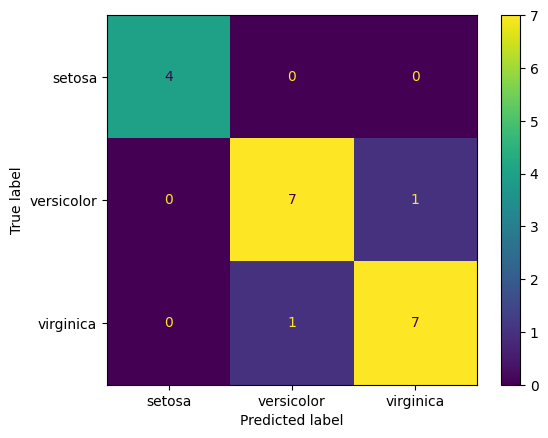

In [22]:
# Plotting confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=class_names)
plt.show()

This is how we can create a decision tree from scratch using python.

## Key Takeaways

* Given an algorithm for decision tree, we can use python to implement it from scratch.

* Scikit-learn uses a modified version of __CART__ to create decision tree. If you want to create decision tree based on other algorithms, you can follow the process used in this chapter.

## Additional Resources

### Decision Tree Implementation:
* Google Developers, [Decision Tree from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)



